### Logistic Regression for Classification

#### Logistic regression with Numpy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
# Import training data
data = pd.read_csv('https://raw.githubusercontent.com/johnmyleswhite/ML_for_Hackers/master/02-Exploration/data/01_heights_weights_genders.csv')

In [16]:
# Label T (0 for Male, 1 for Female), height, and weight for 10,000 data points 
T = np.array([0. if x=='Male' else 1. for x in data['Gender'].values])
H = data['Height'].values
W = data['Weight'].values

print('Mean height: '+str(np.round(H.mean(), 2)))
print('Mean weight: '+str(np.round(W.mean(), 2)))

Mean height: 66.37
Mean weight: 161.44


First, we need to **scale** our data to be in similar ranges. Machine learning algorithms work better if the ranges of each dimension are similar.

In [19]:
# Creating new varialbes H_scaled and W_scaled. Split dataset for men and women.

H_scaled = (H-H.mean())/H.std()
W_scaled = (W-W.mean())/W.std()
mask = (T == 0)
H_males = H_scaled[mask]
W_males = W_scaled[mask]

mask = (T == 1)
H_females = H_scaled[mask]
W_females = W_scaled[mask]

Make a scatter plot of our data.

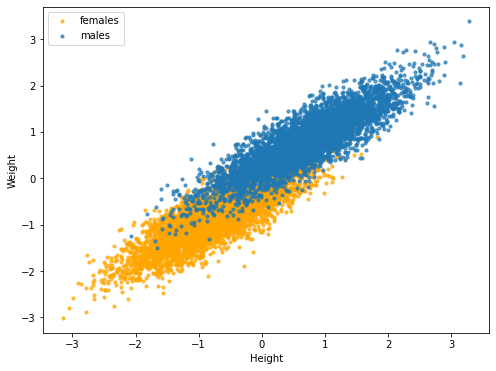

In [24]:
plt.figure(figsize=(8,6))
plt.scatter(H_females, W_females, color = 'orange', label = 'females', s = 10, alpha=.7)
plt.scatter(H_males, W_males, label = 'males', s = 10, alpha=.7)
plt.xlabel('Height')
plt.ylabel('Weight')
plt.legend()
plt.show()

Currently, our target vector has shape (N,). However, numpy arrays can't be one-dimensional if we want to take dot products, so we need to reshape our target array into an (N,1) shape. Additionally, we need to turn our input values array from the two (N,) arrays into a singular array of shape (N,2), where 2 is the number of features we have.

In [25]:
T = T.reshape(len(T), 1)
input = np.vstack((H_scaled, W_scaled)).T
print(input.shape)

(10000, 2)


Now we will move onto implementing all that is needed to find an optimal solution for logistic regression using gradient descent.  Our model is defined by
$$
a_n = \boldsymbol{w}^T\boldsymbol{\phi}_n \, ,
$$
$$
y_n = \sigma (a_n) \, .
$$
To start, we will need access to our loss function and our sigmoid. In addition, we will need access to our basis functions $\boldsymbol{\phi}_n$. In this case, $\boldsymbol{\phi}_n = [1, \boldsymbol{x}_n]$ so that we extend our model to include a bias.

In [26]:
def sigmoid(x):
    
  f = 1/(1+np.exp(-x))

  return f


def loss(t,y):
    
    # Binary Cross Entropy between vector of targets t and vector of predictions y
    E = -(t*np.log(y+10e-15) + (1-t)*np.log(1-y+10e-15))
    E = sum(sum(E))

    return E
    

def phi(x):
  
  Phi = np.ones((len(x), 1))
  Phi = np.hstack((Phi, x))

  return Phi

Next, we implement our gradient descent. We define a function called `gradient_descent` that takes as input the dataset transformed and in the form of basis $\boldsymbol{\phi}$, the target values, the initial values of the parameters $\boldsymbol{w}$, the number of iterations to perform, and the learning rate. It should return the loss history (the value of the loss at each iteration step) as well as the final value of $\boldsymbol{w}$. 

In [27]:
def gradient_descent(input, φ, T, w, iter, learning_rate):
    
  loss_history = []
  w_list = []

  for i in range(iter):

    a = (w).dot(φ)
    y = sigmoid(a).T

    # print(y.shape)
    # print(T.shape)
    loss_history.append(loss(T,y))
    w_list.append(w)

    w = w - learning_rate*sum(((y-T).T.dot(φ.T)))

  return loss_history, w_list, y


Now we are ready to train our model.

In [28]:
# Transform X into phi using the function you wrote above

φ = phi(input)
φ = φ.reshape(3,10000)


# In order to start gradient descent, we initialize our parameters

iter = 1500
learning_rate = 0.0001

## We use our gradient_descent function here using the intiailizations from above

w = np.random.rand(3).reshape(1,3)
loss_history, w_list, y = gradient_descent(input, φ, T, w, iter, learning_rate)

If we choose a high value for the lerning rate we can see the oscilation of the loss function because it always skips the minimum due to the high learning rate. 

In [29]:
w_best = np.array(w_list[-1])
a = phi(input).dot(w_best.T)
y = sigmoid(a)

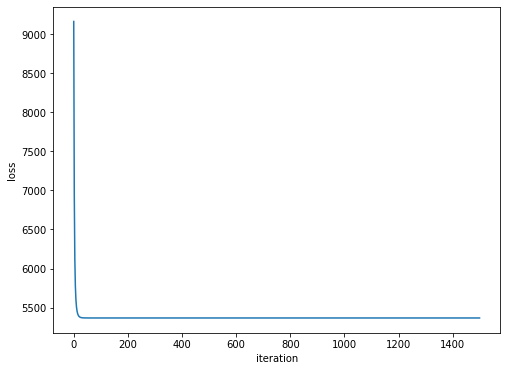

In [35]:
plt.figure(figsize=(8,6))
plt.plot(loss_history)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.show()

As expected after every iteration we have lower loss.

Now we will plot our data showing the output of the logistic regression model.

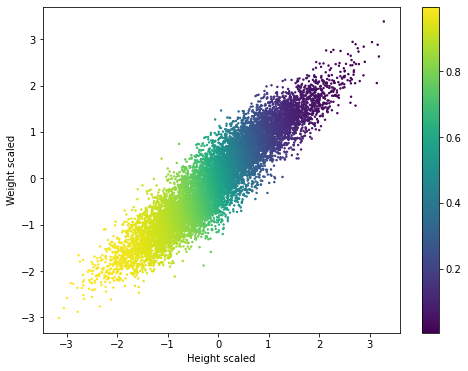

In [48]:
# Remember label T (0 for Male, 1 for Female)
plt.figure(figsize=(8,6))
plt.scatter(H_scaled, W_scaled, c = y, s = 2)
plt.colorbar()
plt.xlabel('Height scaled')
plt.ylabel('Weight scaled')
plt.show()

We can see that the lower the probability $<0.5$ the higher the height and weight of this person which probably represent a male. By taking a limit of .5 declaring that any probability below this equals 0 (male) and above this equals 1 we can seperate the outcome of this plot to 2 sections. 

### Logistic Regression with Pytorch

In [39]:
import torch

First we define the model. We will use only one linear layer. The `forward` function simply computes the value of the prediction `y` given the model parameters.

In [40]:
class LogisticRegression(torch.nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(2,1)

    def forward(self,x):
        y = torch.sigmoid(self.linear(x))
        return y

Defining the criterion and optimizer. We use the built-in torch functions to define a binary cross-entropy loss.
We implement batch gradient descent through torch.optim.SGD. This will implement gradient descent on the batch the model receives, since we are passing the whole dataset at once there is nothing stochastic in our case.

In [41]:
model = LogisticRegression()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)

In [43]:
# convert input data to tensors 
X_tensor = torch.from_numpy(input).to(torch.float)
T_tensor = torch.from_numpy(T).to(torch.float)

`model.train()` is the first step in the training routine. 
 We define a loop that does the following things:

- Zero's the gradient, because the gradient of the loss function is what is updating our model weights. We don't want this to be accidentally doing weird things and then the wrong values update our weights.
- Call the model on our X values to make predictions.
- Evaluate the predictions using the loss.
- Evaluate the gradient of the loss.
- Take an optimizer step.

In [44]:
model.train()

for epoch in range(30000):
    optimizer.zero_grad()

    # forward pass
    Y_pred = model(X_tensor)

    # compute loss
    loss = criterion(Y_pred, T_tensor)
    if epoch% 1000 == 0:
        print(loss.item())
    # backward pass
    loss.backward()
    optimizer.step()

0.6399393677711487
0.27925893664360046
0.2605157792568207
0.24955935776233673
0.24157515168190002
0.23547887802124023
0.23073679208755493
0.2269997000694275
0.2240208238363266
0.22162163257598877
0.2196711152791977
0.218071848154068
0.21675056219100952
0.21565154194831848
0.21473178267478943
0.2139577865600586
0.21330325305461884
0.212747260928154
0.21227304637432098
0.21186710894107819
0.21151848137378693
0.21121816337108612
0.21095865964889526
0.21073397994041443
0.210538849234581
0.21036913990974426
0.21022124588489532
0.21009203791618347
0.20997902750968933
0.2098800241947174


Now let's plot our results.

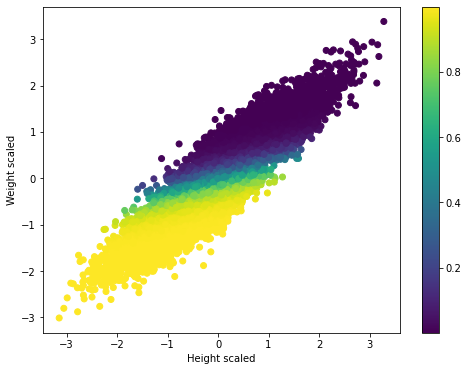

In [49]:
model.eval()
c = [model(torch.tensor([h, w], dtype=torch.float)).detach().numpy() for h, w in zip(H_scaled, W_scaled)]
plt.figure(figsize=(8,6))
plt.scatter(H_scaled, W_scaled, c =c)
plt.xlabel('Height scaled')
plt.ylabel('Weight scaled')
plt.colorbar()
plt.show()